In [1]:
%matplotlib widget
from src.config import DATA_DIR
from src.utils import set_axes_equal
import h5py
import numpy as np
np.set_printoptions(precision=3, suppress=True)
import matplotlib.pyplot as plt
import os
import glob
import mediapy as media
import cv2
from scipy.spatial.distance import directed_hausdorff
# from sklearn.linear_model import LinearRegression

In [2]:
f = h5py.File("/home/jannik/Repos/demonstration-interface/data/session_20240626_115438/episode_20240626_115924.h5",'r')
for key in f.keys():
    print(f"{f[key].dtype}\t {key}{f[key].shape}")

uint8	 color_images(146, 480, 640, 3)
uint16	 depth_images(146, 480, 640)
uint8	 gripper_states(146,)
uint64	 gripper_timestamps(146,)
uint64	 image_timestamps(146,)
uint8	 pose_confidences(146,)
uint64	 pose_timestamps(146,)
float64	 pose_values(146, 4, 4)
uint64	 timestamps(146,)
uint8	 tracker_images(146, 720, 1280, 4)
uint8	 trigger_states(146,)
uint64	 trigger_timestamps(146,)


In [3]:
timestamps = np.array(f["timestamps"])

color_images = np.array(f['color_images'])
color_images = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in color_images])

depth_images = np.array(f['depth_images'])
depth_images = cv2.normalize(depth_images, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_32F)

trigger_states = np.array(f['trigger_states'])
gripper_states = np.array(f['gripper_states'])

tracker_images = np.array(f['tracker_images'])
tracker_images = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in tracker_images])

poses = np.array(f['pose_values'])
confidences = np.array(f['pose_confidences'])

In [4]:
tracker_images.shape

(146, 720, 1280, 3)

In [5]:
media.show_videos([color_images,tracker_images], fps=30, columns=2, width=600)

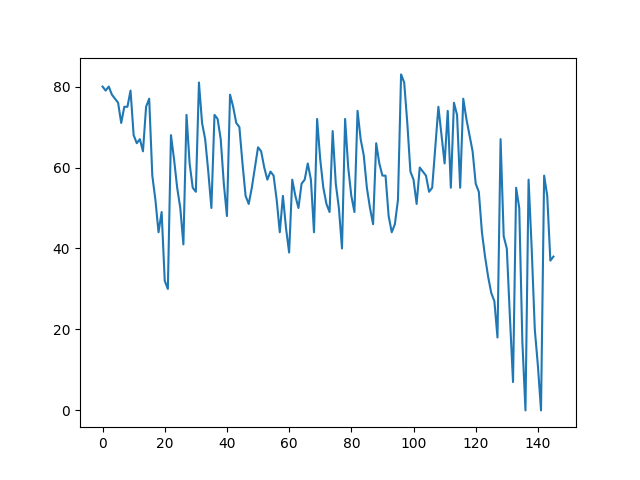

56.38356164383562


In [6]:
plt.figure()
plt.plot(range(len(confidences)),confidences)
plt.show()
print(np.mean(confidences))

In [7]:
# translations = poses[:,:3,3]*1000

In [8]:
# plt.figure()
# plt.plot(translations[:,0], translations[:,2])
# plt.xlim(-20, 320)
# plt.ylim(-10, 320)
# plt.show()

In [9]:
def fit_line_3d(points):
    # Center the data
    mean_point = points.mean(axis=0)
    centered_points = points - mean_point

    # Perform SVD
    _, _, vh = np.linalg.svd(centered_points)

    # The direction of the line is given by the first principal component
    line_direction = vh[0]

    # The point on the line can be the mean of the points
    line_point = mean_point

    return line_point, line_direction

def calculate_error(points, line_point, line_direction):
    # Normalize the direction vector
    line_direction = line_direction / np.linalg.norm(line_direction)

    # Calculate the projection of each point onto the line
    projections = line_point + np.dot(points - line_point, line_direction)[:, np.newaxis] * line_direction

    # Calculate the distance from each point to its projection
    distances = np.linalg.norm(points - projections, axis=1)

    # Calculate total error and mean squared error
    total_error = np.sum(distances)
    mean_squared_error = np.mean(distances ** 2)

    return distances, total_error, mean_squared_error

def calculate_ate(ground_truth, estimated):
    """
    Calculates the Absolute Trajectory Error (ATE).

    Parameters:
    ground_truth (numpy.ndarray): A Nx3 matrix representing the ground truth trajectory.
    estimated (numpy.ndarray): A Nx3 matrix representing the estimated trajectory.

    Returns:
    ate (float): The root mean square error of the ATE.
    """
    assert ground_truth.shape == estimated.shape, "Trajectories must have the same shape"

    # Align the trajectories using a rigid transformation (e.g., Umeyama algorithm)
    mu1 = ground_truth.mean(axis=0)
    mu2 = estimated.mean(axis=0)

    centered_ground_truth = ground_truth - mu1
    centered_estimated = estimated - mu2

    W = np.dot(centered_ground_truth.T, centered_estimated)
    U, _, Vt = np.linalg.svd(W)
    R = np.dot(U, Vt)
    t = mu1 - np.dot(R, mu2)

    aligned_estimated = np.dot(estimated, R.T) + t

    # Calculate the Euclidean distances between corresponding points
    errors = np.linalg.norm(aligned_estimated - ground_truth, axis=1)

    # Calculate the RMSE
    ate = np.sqrt(np.mean(errors**2))

    return ate

In [10]:
#line_point, line_direction = fit_line_3d(translations)
##distances, total_error, mean_squared_error = calculate_error(translations, line_point, line_direction)

In [11]:
#print(mean_squared_error)

In [13]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(translations[:, 0], translations[:, 1], translations[:, 2], label='Data points', marker=".")

# # Define the line for plotting
# t = np.linspace(-200, 200, 100)
# line = line_point + t[:, np.newaxis] * line_direction

# ax.plot(line[:, 0], line[:, 1], line[:, 2], color='red', label='Fitted line')
# set_axes_equal(ax)
# ax.legend()
# plt.show()

In [14]:
# increments = 1000
# z_up = np.linspace(0, 300, increments)
# z_down = np.linspace(300, 0, increments)
# z_trajectory = np.concatenate((z_up, z_down))
# x_trajectory = np.zeros_like(z_trajectory)
# y_trajectory = np.zeros_like(z_trajectory)
# ground_truth = np.vstack((x_trajectory, y_trajectory, z_trajectory)).T

In [15]:
# # ground_truth = np.array([[0,0,0],[0,0,300],[0,0,0]])
# print(ground_truth.shape)
# print(translations.shape)

# # Calculate the directed Hausdorff distance
# d_hausdorff_1_to_2 = directed_hausdorff(ground_truth, translations)[0]
# d_hausdorff_2_to_1 = directed_hausdorff(translations, ground_truth)[0]

# # Print the directed Hausdorff distances
# print(f"The directed Hausdorff distance from path1 to path2 is: {d_hausdorff_1_to_2:.4} mm")
# print(f"The directed Hausdorff distance from path2 to path1 is: {d_hausdorff_2_to_1:.4} mm")

# # The Hausdorff distance is the maximum of these two directed distances
# #hausdorff_distance = max(d_hausdorff_1_to_2, d_hausdorff_2_to_1)
# #print(f"The Hausdorff distance between the two paths is: {hausdorff_distance}")

In [ ]:
# media.show_video(depth_images, fps=30)

In [16]:
def extract_translation(pose_matrix):
    return pose_matrix[:3, 3]

def extract_orientation(pose_matrix):
    return pose_matrix[:3, :3]

def transform_pose(pose, transformation):
    return np.dot(transformation, pose)

def set_axes_equal(ax):
    """
    Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    """

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])


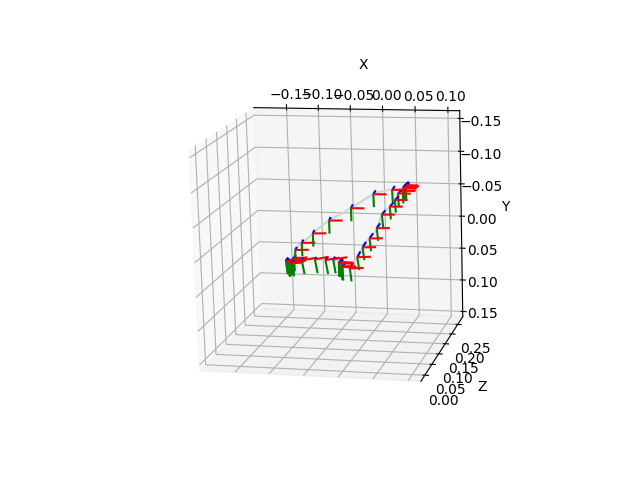

In [18]:
translations = np.array([extract_translation(pose) for pose in poses])
orientations = np.array([extract_orientation(pose) for pose in poses])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')    
ax.set_box_aspect([1.0, 1.0, 1.0])
    
# Plot trajectory
ax.plot(translations[:, 0], translations[:, 1], translations[:, 2], '-', c="lightgrey", label='Trajectory')

translations = translations[::3]
orientations = orientations[::3]

# Plot orientation arrows
for i in range(len(translations)):
    t = translations[i]
    R = orientations[i]
    # R = np.dot(R_z, orientations[i])
    ax.quiver(t[0], t[1], t[2], R[0, 0], R[1, 0], R[2, 0], length=0.02, color='r', arrow_length_ratio=0)
    ax.quiver(t[0], t[1], t[2], R[0, 1], R[1, 1], R[2, 1], length=0.02, color='g', arrow_length_ratio=0)
    ax.quiver(t[0], t[1], t[2], R[0, 2], R[1, 2], R[2, 2], length=0.02, color='b', arrow_length_ratio=0)
    
# ax.quiver(0,0,0, 1, 0, 0, length=200, color='r', arrow_length_ratio=0)
# ax.quiver(0,0,0, 0,1,0, length=200, color='g', arrow_length_ratio=0)
# ax.quiver(0,0,0, 0,0,1, length=200, color='b', arrow_length_ratio=0)
    
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
    
ax.grid(True)
ax.view_init(elev=-70, azim=-45, roll=-45)

set_axes_equal(ax)
plt.show()